In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Go to Depmap data: https://cds.team/taiga/dataset/internal-24q4-8c04/117 and use the AUC data from Prism 
#then find AUC, Hotspot and Batchcorrected

In [3]:
from taigapy import create_taiga_client_v3
tc = create_taiga_client_v3()

In [4]:
prism_auc = tc.get('internal-24q4-8c04.117/PRISMOncologyReferenceAUCMatrix')


In [5]:
hs_mutations = tc.get('internal-24q4-8c04.117/OmicsSomaticMutationsMatrixHotspot')


In [6]:
expr = tc.get('internal-24q4-8c04.117/OmicsExpressionProteinCodingGenesTPMLogp1BatchCorrected')


In [7]:
portal_compounds = tc.get('internal-24q4-8c04.117/PortalCompounds')

In [7]:
#the data is not very clean so here we are going to clean it, in terms of SampleIDs first, we split the name and then we re-merged to the data

In [8]:
portal_compounds
#you will SampleIDs, different places have different IDs based on the experiments that were run using the drug


,CompoundID,CompoundName,GeneSymbolOfTargets,TargetOrMechanism,Synonyms,SampleIDs,ChEMBLID,SMILES,InChIKey,DoseUnit,PubChemCID
0,DPC-000001,(+)-CAMPTOTHECIN,TOP1,TOPOISOMERASE INHIBITOR,CAMPTOTHECIN;CAMPTOTHECINE,BRD:BRD-K37890730-001-15-1;GDSC2:1003,None,None,None,uM,None
1,DPC-000002,(+)-JQ-1,None,None,JQ-1;JQ1,CTRP:616354;GDSC1:1218;GDSC1:163;GDSC2:2172,None,None,None,uM,None
2,DPC-000003,(5Z)-7-OXOZEAENOL,None,None,5Z-7-OXOZEAENOL;LL-Z1640-2,GDSC1:1242,None,None,None,uM,None
3,DPC-000004,(R)-(-)-APOMORPHINE,ADRA2A;ADRA2B;ADRA2C;CALY;DRD1;DRD2;DRD3;DRD4;...,DOPAMINE RECEPTOR AGONIST,R(-)-APOMORPHINE,BRD:BRD-K76022557-003-02-7,None,None,None,uM,None
4,DPC-000005,(R)-(-)-ROLIPRAM,PDE4A;PDE4B;PDE4C;PDE4D;PDE5A,PHOSPHODIESTERASE INHIBITOR,ROLIPRAM-R(-),BRD:BRD-K75516118-001-03-3,None,None,None,uM,None
...,...,...,...,...,...,...,...,...,...,...,...
7140,DPC-07266,TIGOZERTINIB,EGFR,"inhibitor of EGFR, including L858R-, T790M-, a...",BLU-945;ZL-2313,BRD:PRC-006870112-266-27,CHEMBL14253,CC1C(CN1C2=C3C=NC(=CC3=C(C=C2)C(C)C)NC4=NC(=NC...,LIMFPAAAIVQRRD-BCGVJQADSA-N,uM,156538665
7141,DPC-07267,SI-109,STAT3,inhibitor of STAT3,None,BRD:PRC-003598735-014-10,CHEMBL14253,CC(=O)N1CCC2CCC(N2C(=O)C(C1)NC(=O)C3=CC4=C(N3)...,HBICZHLVBCLHSV-VUCLUUCHSA-N,uM,139600322
7142,DPC-07268,SD-36,STAT3,CRBN-based PROTAC degrader of STAT3,None,BRD:PRC-006576713-504-55,CHEMBL14253,C1CC(N2C1CCN(CC(C2=O)NC(=O)C3=CC4=C(N3)C=CC(=C...,JKCSCHXVWPSGBG-OPKPGBGESA-N,uM,139600321
7143,DPC-07269,NERANDOMILAST,PDE4B,inhibitor of PDE4B,BI-1015550,BRD:PRC-009892143-922-64,CHEMBL14253,C1CC(C1)(CO)NC2=NC(=NC3=C2S(=O)CC3)N4CCC(CC4)C...,UHYCLWAANUGUMN-SSEXGKCCSA-N,uM,166177189


In [9]:
#the way that our PRISM oncology dataset is organised, all drugs names start with PRC sth sth sth, so let's split the name
portal_compounds[['CompoundID', 'CompoundName', 'SampleIDs']].set_index('CompoundID').SampleIDs.str.split(';')

CompoundID
DPC-000001            [BRD:BRD-K37890730-001-15-1, GDSC2:1003]
DPC-000002    [CTRP:616354, GDSC1:1218, GDSC1:163, GDSC2:2172]
DPC-000003                                        [GDSC1:1242]
DPC-000004                        [BRD:BRD-K76022557-003-02-7]
DPC-000005                        [BRD:BRD-K75516118-001-03-3]
                                    ...                       
DPC-07266                           [BRD:PRC-006870112-266-27]
DPC-07267                           [BRD:PRC-003598735-014-10]
DPC-07268                           [BRD:PRC-006576713-504-55]
DPC-07269                           [BRD:PRC-009892143-922-64]
DPC-07270                           [BRD:PRC-005867626-809-28]
Name: SampleIDs, Length: 7145, dtype: object

In [10]:
#now we split out each ID into its own row
compounds_exploded = portal_compounds[['CompoundID', 'CompoundName', 'SampleIDs']].set_index('CompoundID').SampleIDs.str.split(';').explode()

In [11]:
compounds_exploded

CompoundID
DPC-000001    BRD:BRD-K37890730-001-15-1
DPC-000001                    GDSC2:1003
DPC-000002                   CTRP:616354
DPC-000002                    GDSC1:1218
DPC-000002                     GDSC1:163
                         ...            
DPC-07266       BRD:PRC-006870112-266-27
DPC-07267       BRD:PRC-003598735-014-10
DPC-07268       BRD:PRC-006576713-504-55
DPC-07269       BRD:PRC-009892143-922-64
DPC-07270       BRD:PRC-005867626-809-28
Name: SampleIDs, Length: 8185, dtype: object

In [12]:
#it knows which column you are renaming, because it was a series not a column, it says so at the bottom of the previous 
comp_meta_exp = (
    portal_compounds.drop('SampleIDs',axis=1)
    .merge(compounds_exploded.rename('SampleID'),left_on='CompoundID',right_index=True)
)


In [13]:
comp_meta_exp

,CompoundID,CompoundName,GeneSymbolOfTargets,TargetOrMechanism,Synonyms,ChEMBLID,SMILES,InChIKey,DoseUnit,PubChemCID,SampleID
0,DPC-000001,(+)-CAMPTOTHECIN,TOP1,TOPOISOMERASE INHIBITOR,CAMPTOTHECIN;CAMPTOTHECINE,None,None,None,uM,None,BRD:BRD-K37890730-001-15-1
0,DPC-000001,(+)-CAMPTOTHECIN,TOP1,TOPOISOMERASE INHIBITOR,CAMPTOTHECIN;CAMPTOTHECINE,None,None,None,uM,None,GDSC2:1003
1,DPC-000002,(+)-JQ-1,None,None,JQ-1;JQ1,None,None,None,uM,None,CTRP:616354
1,DPC-000002,(+)-JQ-1,None,None,JQ-1;JQ1,None,None,None,uM,None,GDSC1:1218
1,DPC-000002,(+)-JQ-1,None,None,JQ-1;JQ1,None,None,None,uM,None,GDSC1:163
...,...,...,...,...,...,...,...,...,...,...,...
7140,DPC-07266,TIGOZERTINIB,EGFR,"inhibitor of EGFR, including L858R-, T790M-, a...",BLU-945;ZL-2313,CHEMBL14253,CC1C(CN1C2=C3C=NC(=CC3=C(C=C2)C(C)C)NC4=NC(=NC...,LIMFPAAAIVQRRD-BCGVJQADSA-N,uM,156538665,BRD:PRC-006870112-266-27
7141,DPC-07267,SI-109,STAT3,inhibitor of STAT3,None,CHEMBL14253,CC(=O)N1CCC2CCC(N2C(=O)C(C1)NC(=O)C3=CC4=C(N3)...,HBICZHLVBCLHSV-VUCLUUCHSA-N,uM,139600322,BRD:PRC-003598735-014-10
7142,DPC-07268,SD-36,STAT3,CRBN-based PROTAC degrader of STAT3,None,CHEMBL14253,C1CC(N2C1CCN(CC(C2=O)NC(=O)C3=CC4=C(N3)C=CC(=C...,JKCSCHXVWPSGBG-OPKPGBGESA-N,uM,139600321,BRD:PRC-006576713-504-55
7143,DPC-07269,NERANDOMILAST,PDE4B,inhibitor of PDE4B,BI-1015550,CHEMBL14253,C1CC(C1)(CO)NC2=NC(=NC3=C2S(=O)CC3)N4CCC(CC4)C...,UHYCLWAANUGUMN-SSEXGKCCSA-N,uM,166177189,BRD:PRC-009892143-922-64


In [14]:
prism_compounds = comp_meta_exp[comp_meta_exp.SampleID.str.startswith('BRD')]
prism_compounds['SampleID'] = prism_compounds.SampleID.str.extract(r'BRD:([A-Za-z0-9\-]+)')[0]
oncref_compounds = prism_compounds[prism_compounds.SampleID.str.startswith('PRC')]
oncref_compounds

/tmp/ipykernel_79173/411104792.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prism_compounds['SampleID'] = prism_compounds.SampleID.str.extract(r'BRD:([A-Za-z0-9\-]+)')[0]


,CompoundID,CompoundName,GeneSymbolOfTargets,TargetOrMechanism,Synonyms,ChEMBLID,SMILES,InChIKey,DoseUnit,PubChemCID,SampleID
140,DPC-000141,AZACITIDINE,DNMT1,covalent inhibitor of DNMT1; hypomethylating a...,5-AZACYTIDINE;AZACYTIDINE,CHEMBL14253,C1=NC(=NC(=O)N1C2C(C(C(O2)CO)O)O)N,NMUSYJAQQFHJEW-KVTDHHQDSA-N,uM,9444,PRC-008632586-537-09
186,DPC-000187,A-1331852,BCL2L1,inhibitor of BCL-xL (BCL2L1),None,CHEMBL14253,CC1=C(C=NN1CC23CC4CC(C2)CC(C4)C3)C5=C(N=C(C=C5...,QCQQONWEDCOTBV-UHFFFAOYSA-N,uM,71565985,PRC-005868644-712-80
190,DPC-000191,A-366,EHMT1; EHMT2,inhibitor of GLP (EHMT1) and G9a (EHMT2) histo...,None,CHEMBL14253,COC1=C(C=C2C(=C1)C3(CCC3)C(=N2)N)OCCCN4CCCC4,BKCDJTRMYWSXMC-UHFFFAOYSA-N,uM,76285486,PRC-003859103-281-25
213,DPC-000214,A485,EP300;CREBBP,inhibitor of p300/CBP (EP300/CREBBP) catalytic...,A-485,CHEMBL14253,CC(C(F)(F)F)N(CC1=CC=C(C=C1)F)C(=O)CN2C(=O)C3(...,VRVJKILQRBSEAG-LFPIHBKWSA-N,uM,118958122,PRC-004116817-719-36
217,DPC-000218,A939572,SCD,inhibitor of SCD,A-939572,CHEMBL14253,CNC(=O)C1=CC(=CC=C1)NC(=O)N2CCC(CC2)OC3=CC=CC=...,DPYTYQFYDLYWHZ-UHFFFAOYSA-N,uM,24905400,PRC-003785376-320-47
...,...,...,...,...,...,...,...,...,...,...,...
7140,DPC-07266,TIGOZERTINIB,EGFR,"inhibitor of EGFR, including L858R-, T790M-, a...",BLU-945;ZL-2313,CHEMBL14253,CC1C(CN1C2=C3C=NC(=CC3=C(C=C2)C(C)C)NC4=NC(=NC...,LIMFPAAAIVQRRD-BCGVJQADSA-N,uM,156538665,PRC-006870112-266-27
7141,DPC-07267,SI-109,STAT3,inhibitor of STAT3,None,CHEMBL14253,CC(=O)N1CCC2CCC(N2C(=O)C(C1)NC(=O)C3=CC4=C(N3)...,HBICZHLVBCLHSV-VUCLUUCHSA-N,uM,139600322,PRC-003598735-014-10
7142,DPC-07268,SD-36,STAT3,CRBN-based PROTAC degrader of STAT3,None,CHEMBL14253,C1CC(N2C1CCN(CC(C2=O)NC(=O)C3=CC4=C(N3)C=CC(=C...,JKCSCHXVWPSGBG-OPKPGBGESA-N,uM,139600321,PRC-006576713-504-55
7143,DPC-07269,NERANDOMILAST,PDE4B,inhibitor of PDE4B,BI-1015550,CHEMBL14253,C1CC(C1)(CO)NC2=NC(=NC3=C2S(=O)CC3)N4CCC(CC4)C...,UHYCLWAANUGUMN-SSEXGKCCSA-N,uM,166177189,PRC-009892143-922-64


In [15]:
mdm_inh = oncref_compounds[~oncref_compounds.GeneSymbolOfTargets.isna() &
                 oncref_compounds.GeneSymbolOfTargets.str.contains('MDM')].SampleID

mdm_inh
#the drug name has 3 different inhibitors and we will try to see how well they work
#the AUC will be used to see how much these drugs affect a population of cells
#then we will stratify based on biomarkes

3338    PRC-006576151-588-97
4679    PRC-007285892-332-48
7135    PRC-002474151-635-43
Name: SampleID, dtype: object

In [16]:
#some more extraction
mdm_data = (
    prism_auc[mdm_inh].melt(value_vars=mdm_inh.to_list(),ignore_index=False).reset_index()
    .rename(columns={'index':'ModelID', 'variable':'PRC_ID', 'value':'AUC'})
    .dropna().merge(oncref_compounds[oncref_compounds.SampleID.isin(mdm_inh)],
                    left_on='PRC_ID', right_on='SampleID')
    .merge((hs_mutations['TP53 (7157)']>0), 
                    left_on='ModelID',right_index=True)
    .merge(expr['MDM2 (4193)'],left_on='ModelID',right_index=True)
    .rename(columns={'TP53 (7157)':'TP_mut','MDM2 (4193)':'MDM2_exp'})
)
mdm_data

,ModelID,PRC_ID,AUC,CompoundID,CompoundName,GeneSymbolOfTargets,TargetOrMechanism,Synonyms,ChEMBLID,SMILES,InChIKey,DoseUnit,PubChemCID,SampleID,TP_mut,MDM2_exp
0,ACH-000001,PRC-006576151-588-97,1.000000,DPC-003347,IDASANUTLIN,TP53;MDM2;MDM4,inhibitor of TP53/MDM2/4 interaction,RG7388,CHEMBL14253,CC(C)(C)CC1C(C(C(N1)C(=O)NC2=C(C=C(C=C2)C(=O)O...,TVTXCJFHQKSQQM-LJQIRTBHSA-N,uM,53358942,PRC-006576151-588-97,True,4.516697
1,ACH-000002,PRC-006576151-588-97,1.000000,DPC-003347,IDASANUTLIN,TP53;MDM2;MDM4,inhibitor of TP53/MDM2/4 interaction,RG7388,CHEMBL14253,CC(C)(C)CC1C(C(C(N1)C(=O)NC2=C(C=C(C=C2)C(=O)O...,TVTXCJFHQKSQQM-LJQIRTBHSA-N,uM,53358942,PRC-006576151-588-97,False,5.488961
2,ACH-000004,PRC-006576151-588-97,1.000000,DPC-003347,IDASANUTLIN,TP53;MDM2;MDM4,inhibitor of TP53/MDM2/4 interaction,RG7388,CHEMBL14253,CC(C)(C)CC1C(C(C(N1)C(=O)NC2=C(C=C(C=C2)C(=O)O...,TVTXCJFHQKSQQM-LJQIRTBHSA-N,uM,53358942,PRC-006576151-588-97,True,4.187575
3,ACH-000005,PRC-006576151-588-97,1.000000,DPC-003347,IDASANUTLIN,TP53;MDM2;MDM4,inhibitor of TP53/MDM2/4 interaction,RG7388,CHEMBL14253,CC(C)(C)CC1C(C(C(N1)C(=O)NC2=C(C=C(C=C2)C(=O)O...,TVTXCJFHQKSQQM-LJQIRTBHSA-N,uM,53358942,PRC-006576151-588-97,True,5.453174
4,ACH-000006,PRC-006576151-588-97,0.971790,DPC-003347,IDASANUTLIN,TP53;MDM2;MDM4,inhibitor of TP53/MDM2/4 interaction,RG7388,CHEMBL14253,CC(C)(C)CC1C(C(C(N1)C(=O)NC2=C(C=C(C=C2)C(=O)O...,TVTXCJFHQKSQQM-LJQIRTBHSA-N,uM,53358942,PRC-006576151-588-97,True,3.610839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2561,ACH-002039,PRC-002474151-635-43,1.000000,DPC-07261,BRIGIMADLIN,TP53;MDM2;MDM4,inhibitor of TP53/MDM2/4 interaction,BI 907828,CHEMBL14253,CC1=C(C=CC2=C3CC4C(N3N=C12)C(C5(N4CC6CC6)C7=C(...,AMTXDBGKYPDTTA-SJVQGLCSSA-N,uM,129264140,PRC-002474151-635-43,True,4.790086
2562,ACH-002041,PRC-002474151-635-43,0.873202,DPC-07261,BRIGIMADLIN,TP53;MDM2;MDM4,inhibitor of TP53/MDM2/4 interaction,BI 907828,CHEMBL14253,CC1=C(C=CC2=C3CC4C(N3N=C12)C(C5(N4CC6CC6)C7=C(...,AMTXDBGKYPDTTA-SJVQGLCSSA-N,uM,129264140,PRC-002474151-635-43,True,3.695644
2563,ACH-002042,PRC-002474151-635-43,0.948876,DPC-07261,BRIGIMADLIN,TP53;MDM2;MDM4,inhibitor of TP53/MDM2/4 interaction,BI 907828,CHEMBL14253,CC1=C(C=CC2=C3CC4C(N3N=C12)C(C5(N4CC6CC6)C7=C(...,AMTXDBGKYPDTTA-SJVQGLCSSA-N,uM,129264140,PRC-002474151-635-43,False,5.455876
2564,ACH-002046,PRC-002474151-635-43,1.000000,DPC-07261,BRIGIMADLIN,TP53;MDM2;MDM4,inhibitor of TP53/MDM2/4 interaction,BI 907828,CHEMBL14253,CC1=C(C=CC2=C3CC4C(N3N=C12)C(C5(N4CC6CC6)C7=C(...,AMTXDBGKYPDTTA-SJVQGLCSSA-N,uM,129264140,PRC-002474151-635-43,True,4.667288


In [17]:
mdm_data=(
    prism_auc[mdm_inh].melt(value_vars=mdm_inh.to_list(),ignore_index=False).reset_index()
    .rename(columns={'index':'ModelID','variable': 'PRC_ID','value':'AUC'})
    .dropna().merge(oncref_compounds[oncref_compounds.SampleID.isin(mdm_inh)],
                    left_on='PRC_ID',right_on='SampleID')
    .merge((hs_mutations['TP53 (7157)']>0),left_on='ModelID',right_index=True)
    .merge(expr["MDM2 (4193)"],left_on='ModelID',right_index=True)
    .rename(columns={'TP53 (7157)':'TP53_mut','MDM2 (4193)':'MDM2_expr'})
)
mdm_data

,ModelID,PRC_ID,AUC,CompoundID,CompoundName,GeneSymbolOfTargets,TargetOrMechanism,Synonyms,ChEMBLID,SMILES,InChIKey,DoseUnit,PubChemCID,SampleID,TP53_mut,MDM2_expr
0,ACH-000001,PRC-006576151-588-97,1.000000,DPC-003347,IDASANUTLIN,TP53;MDM2;MDM4,inhibitor of TP53/MDM2/4 interaction,RG7388,CHEMBL14253,CC(C)(C)CC1C(C(C(N1)C(=O)NC2=C(C=C(C=C2)C(=O)O...,TVTXCJFHQKSQQM-LJQIRTBHSA-N,uM,53358942,PRC-006576151-588-97,True,4.516697
1,ACH-000002,PRC-006576151-588-97,1.000000,DPC-003347,IDASANUTLIN,TP53;MDM2;MDM4,inhibitor of TP53/MDM2/4 interaction,RG7388,CHEMBL14253,CC(C)(C)CC1C(C(C(N1)C(=O)NC2=C(C=C(C=C2)C(=O)O...,TVTXCJFHQKSQQM-LJQIRTBHSA-N,uM,53358942,PRC-006576151-588-97,False,5.488961
2,ACH-000004,PRC-006576151-588-97,1.000000,DPC-003347,IDASANUTLIN,TP53;MDM2;MDM4,inhibitor of TP53/MDM2/4 interaction,RG7388,CHEMBL14253,CC(C)(C)CC1C(C(C(N1)C(=O)NC2=C(C=C(C=C2)C(=O)O...,TVTXCJFHQKSQQM-LJQIRTBHSA-N,uM,53358942,PRC-006576151-588-97,True,4.187575
3,ACH-000005,PRC-006576151-588-97,1.000000,DPC-003347,IDASANUTLIN,TP53;MDM2;MDM4,inhibitor of TP53/MDM2/4 interaction,RG7388,CHEMBL14253,CC(C)(C)CC1C(C(C(N1)C(=O)NC2=C(C=C(C=C2)C(=O)O...,TVTXCJFHQKSQQM-LJQIRTBHSA-N,uM,53358942,PRC-006576151-588-97,True,5.453174
4,ACH-000006,PRC-006576151-588-97,0.971790,DPC-003347,IDASANUTLIN,TP53;MDM2;MDM4,inhibitor of TP53/MDM2/4 interaction,RG7388,CHEMBL14253,CC(C)(C)CC1C(C(C(N1)C(=O)NC2=C(C=C(C=C2)C(=O)O...,TVTXCJFHQKSQQM-LJQIRTBHSA-N,uM,53358942,PRC-006576151-588-97,True,3.610839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2561,ACH-002039,PRC-002474151-635-43,1.000000,DPC-07261,BRIGIMADLIN,TP53;MDM2;MDM4,inhibitor of TP53/MDM2/4 interaction,BI 907828,CHEMBL14253,CC1=C(C=CC2=C3CC4C(N3N=C12)C(C5(N4CC6CC6)C7=C(...,AMTXDBGKYPDTTA-SJVQGLCSSA-N,uM,129264140,PRC-002474151-635-43,True,4.790086
2562,ACH-002041,PRC-002474151-635-43,0.873202,DPC-07261,BRIGIMADLIN,TP53;MDM2;MDM4,inhibitor of TP53/MDM2/4 interaction,BI 907828,CHEMBL14253,CC1=C(C=CC2=C3CC4C(N3N=C12)C(C5(N4CC6CC6)C7=C(...,AMTXDBGKYPDTTA-SJVQGLCSSA-N,uM,129264140,PRC-002474151-635-43,True,3.695644
2563,ACH-002042,PRC-002474151-635-43,0.948876,DPC-07261,BRIGIMADLIN,TP53;MDM2;MDM4,inhibitor of TP53/MDM2/4 interaction,BI 907828,CHEMBL14253,CC1=C(C=CC2=C3CC4C(N3N=C12)C(C5(N4CC6CC6)C7=C(...,AMTXDBGKYPDTTA-SJVQGLCSSA-N,uM,129264140,PRC-002474151-635-43,False,5.455876
2564,ACH-002046,PRC-002474151-635-43,1.000000,DPC-07261,BRIGIMADLIN,TP53;MDM2;MDM4,inhibitor of TP53/MDM2/4 interaction,BI 907828,CHEMBL14253,CC1=C(C=CC2=C3CC4C(N3N=C12)C(C5(N4CC6CC6)C7=C(...,AMTXDBGKYPDTTA-SJVQGLCSSA-N,uM,129264140,PRC-002474151-635-43,True,4.667288


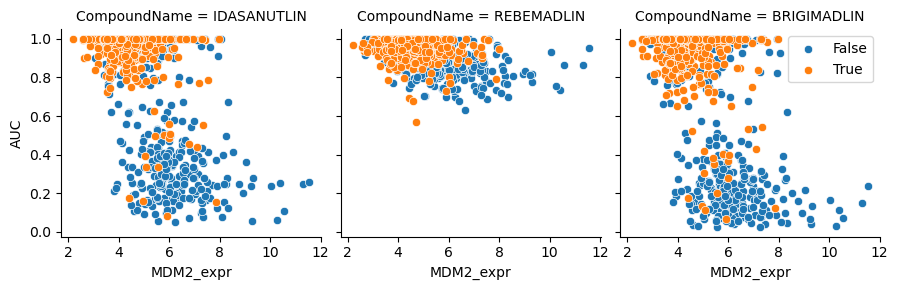

In [18]:
g=sns.FacetGrid(mdm_data,col='CompoundName', col_wrap=3,hue='TP53_mut')
g.map(sns.scatterplot,'MDM2_expr','AUC')
plt.legend()
#we have higher AUC in the mutant than the wild type
#so more effective in the wild type 

#higher AUC means u need a higher dose of the drug to get the same effect

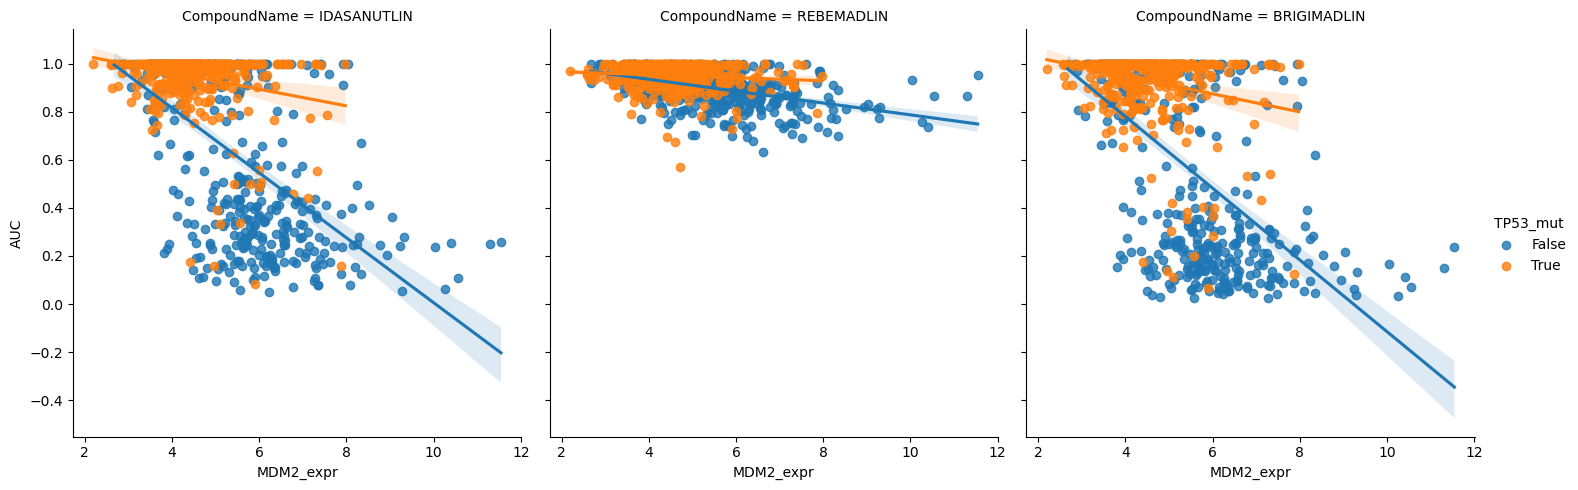

In [19]:
sns.lmplot(data=mdm_data,col='CompoundName',hue='TP53_mut',x='MDM2_expr',y='AUC')


In [8]:
#now let's look at the mutation data
#exercice if we have gene names in a specific way 
gene = tc.get('internal-24q4-8c04.117/Gene')

In [21]:
gene['depmap'] = gene.symbol + ' (' + gene.entrez_id.astype('Int64').astype(str) +')'
gene

,hgnc_id,symbol,name,locus_group,locus_type,status,location,location_sortable,alias_symbol,alias_name,...,lncrnadb,enzyme_id,intermediate_filament_db,rna_central_ids,lncipedia,gtrnadb,agr,mane_select,gencc,depmap
0,HGNC:5,A1BG,alpha-1-B glycoprotein,protein-coding gene,gene with protein product,Approved,19q13.43,19q13.43,None,None,...,None,None,NaN,NaN,None,None,HGNC:5,ENST00000263100.8|NM_130786.4,None,A1BG (1)
1,HGNC:37133,A1BG-AS1,A1BG antisense RNA 1,non-coding RNA,"RNA, long non-coding",Approved,19q13.43,19q13.43,FLJ23569,None,...,None,None,NaN,NaN,A1BG-AS1,None,HGNC:37133,None,None,A1BG-AS1 (503538)
2,HGNC:24086,A1CF,APOBEC1 complementation factor,protein-coding gene,gene with protein product,Approved,10q11.23,10q11.23,ACF|ASP|ACF64|ACF65|APOBEC1CF,None,...,None,None,NaN,NaN,None,None,HGNC:24086,ENST00000373997.8|NM_014576.4,None,A1CF (29974)
3,HGNC:7,A2M,alpha-2-macroglobulin,protein-coding gene,gene with protein product,Approved,12p13.31,12p13.31,FWP007|S863-7|CPAMD5,None,...,None,None,NaN,NaN,None,None,HGNC:7,ENST00000318602.12|NM_000014.6,HGNC:7,A2M (2)
4,HGNC:27057,A2M-AS1,A2M antisense RNA 1,non-coding RNA,"RNA, long non-coding",Approved,12p13.31,12p13.31,None,None,...,None,None,NaN,NaN,A2M-AS1,None,HGNC:27057,None,None,A2M-AS1 (144571)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43834,HGNC:25820,ZYG11B,"zyg-11 family member B, cell cycle regulator",protein-coding gene,gene with protein product,Approved,1p32.3,01p32.3,FLJ13456,None,...,None,None,NaN,NaN,None,None,HGNC:25820,ENST00000294353.7|NM_024646.3,HGNC:25820,ZYG11B (79699)
43835,HGNC:13200,ZYX,zyxin,protein-coding gene,gene with protein product,Approved,7q34,07q34,None,None,...,None,None,NaN,NaN,None,None,HGNC:13200,ENST00000322764.10|NM_003461.5,None,ZYX (7791)
43836,HGNC:51695,ZYXP1,zyxin pseudogene 1,pseudogene,pseudogene,Approved,8q24.23,08q24.23,None,None,...,None,None,NaN,NaN,None,None,HGNC:51695,None,None,ZYXP1 (106480342)
43837,HGNC:29027,ZZEF1,zinc finger ZZ-type and EF-hand domain contain...,protein-coding gene,gene with protein product,Approved,17p13.2,17p13.2,KIAA0399|ZZZ4|FLJ10821,None,...,None,None,NaN,NaN,None,None,HGNC:29027,ENST00000381638.7|NM_015113.4,None,ZZEF1 (23140)


In [22]:
gene[['ensembl_gene_id','depmap']].set_index('depmap')['ensembl_gene_id']

depmap
A1BG (1)             ENSG00000121410
A1BG-AS1 (503538)    ENSG00000268895
A1CF (29974)         ENSG00000148584
A2M (2)              ENSG00000175899
A2M-AS1 (144571)     ENSG00000245105
                          ...       
ZYG11B (79699)       ENSG00000162378
ZYX (7791)           ENSG00000159840
ZYXP1 (106480342)    ENSG00000274572
ZZEF1 (23140)        ENSG00000074755
ZZZ3 (26009)         ENSG00000036549
Name: ensembl_gene_id, Length: 43839, dtype: object

In [23]:
#then we label using the enembl id
hs_mutations.columns = (
   hs_mutations.columns.map(gene[['ensembl_gene_id','depmap']]
                            .set_index('depmap')['ensembl_gene_id']) 
)

In [24]:
hs_mutations

,ENSG00000171608,ENSG00000198793,ENSG00000179023,ENSG00000117713,ENSG00000121903,ENSG00000121904,ENSG00000070785,ENSG00000186603,ENSG00000123473,ENSG00000203963,...,ENSG00000102316,ENSG00000169083,ENSG00000184634,ENSG00000085224,ENSG00000072315,ENSG00000126016,ENSG00000198354,ENSG00000147257,ENSG00000155495,ENSG00000102287
ACH-000062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACH-001949,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACH-003131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACH-000402,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACH-000693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-000083,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACH-000134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACH-000131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACH-000165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Coocurent mutations

In [9]:
hs_mutations = tc.get('internal-24q4-8c04.117/OmicsSomaticMutationsMatrixHotspot')


In [10]:
#
hs_mutations.columns = hs_mutations.columns.map(lambda x: x.split(' ')[0])

In [27]:
kras_egr = hs_mutations[['KRAS','EGFR']]
kras_egr

,KRAS,EGFR
ACH-000062,0.0,0.0
ACH-001949,0.0,0.0
ACH-003131,0.0,0.0
ACH-000402,0.0,0.0
ACH-000693,0.0,0.0
...,...,...
ACH-000083,0.0,0.0
ACH-000134,0.0,0.0
ACH-000131,0.0,0.0
ACH-000165,0.0,0.0


In [28]:
kras_egr = kras_egr >0

In [29]:
kras_egr.value_counts()
#we have zero observation of KRAS and EGFR occuring together

KRAS   EGFR 
False  False    2080
True   False     297
False  True       18
Name: count, dtype: int64

In [30]:
#we will do a fisher exact test
#here we create the contigency table for the test
#how many values do we have from each combination
#pivot does the opposite of melt, pivot changes the shape of the amtrix from 
c_tab = kras_egr.value_counts().reset_index().pivot(index='KRAS',columns='EGFR').fillna(0) #
c_tab

count      
EGFR    False True 
KRAS               
False  2080.0  18.0
True    297.0   0.0

In [31]:
#fishers test
from scipy import stats
ftest = stats.fisher_exact(c_tab)
ftest

SignificanceResult(statistic=np.float64(0.0), pvalue=np.float64(0.15354130433546678))

In [32]:
hs_mutations = hs_mutations >0

In [33]:
hf_muts = hs_mutations.loc[:,hs_mutations.sum()>4] #filter for those that have at elast 4 

In [34]:
def contingency_mat(gene_1,gene_2,muts): #the name of the variable inside a function preferably should not be a name used 
    out = (muts[[gene_1,gene_2]].value_counts().reset_index().pivot(index=gene_1,columns=gene_2))
    out = out.fillna(0).astype(int)
    out.index = [gene_1+'_WT',gene_1+'_MUT']
    out.columns = [gene_2+'_WT',gene_2+'_MUT']
    return out



In [35]:
contingency_mat('EGFR', 'KRAS', hf_muts)

,KRAS_WT,KRAS_MUT
EGFR_WT,2080,297
EGFR_MUT,18,0


In [36]:
contingency_mat('BRAF', 'PTEN', hf_muts)

,PTEN_WT,PTEN_MUT
BRAF_WT,2155,76
BRAF_MUT,161,3


In [37]:
#wrap the contingency matrix function into another function that does a fisher test for us
def is_powered(gene_1, gene_2, mut):
    mat = contingency_mat(gene_1, gene_2, mut)
    tested = stats.fisher_exact(mat)
    out = pd.DataFrame(data = [[tested.statistic,tested.pvalue]],
                       columns = ['odds_ratio','pval'], index=[[gene_1], [gene_2]])
    return out

In [38]:
is_powered('BRAF', 'PTEN', hf_muts)

,,odds_ratio,pval
BRAF,PTEN,0.528359,0.366629


In [39]:
#skip the gene if it is the same one
#concat is a way to stack results on top of each other
gene_pair_results = []

for gene_1, gene_2 in pd.MultiIndex.from_product([hf_muts.columns,hf_muts.columns]):
    if gene_1 == gene_2:
        continue 
    gene_pair_results.append(is_powered(gene_1,gene_2,hf_muts))

df_cooc_results = pd.concat(gene_pair_results) 
df_cooc_results['qval'] = stats.false_discovery_control(df_cooc_results.pval)

In [40]:
df_cooc_results

odds_ratio      pval      qval
MTOR ARID1A   27.835294  0.003754  0.115667
     EIF2B3    0.000000  1.000000  1.000000
     NRAS      1.092271  0.612072  1.000000
     ZNF648    0.000000  1.000000  1.000000
     H3-3A     0.000000  1.000000  1.000000
...                 ...       ...       ...
AR   MYC       0.000000  1.000000  1.000000
     JAK2      0.000000  1.000000  1.000000
     CDKN2A    0.000000  1.000000  1.000000
     GNAQ      0.000000  1.000000  1.000000
     EIF1AX    0.000000  1.000000  1.000000

[8010 rows x 3 columns]

In [41]:
df_cooc_results['log_q'] = -df_cooc_results.qval.apply(np.log10)
df_cooc_results['log_odds'] = df_cooc_results.odds_ratio.apply(np.log2)
df_cooc_results['highlight'] = (df_cooc_results.odds_ratio >300) | (df_cooc_results.qval <0.2)


<Axes: xlabel='log_odds', ylabel='log_q'>

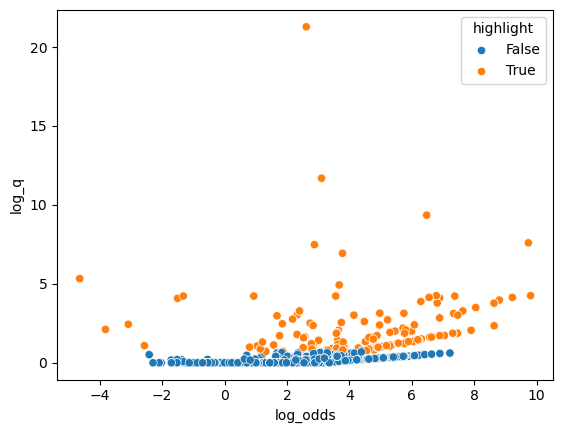

In [42]:
#volcano plot is a scatter plot with fancy axis
sns.scatterplot(data=df_cooc_results,x='log_odds', y='log_q', hue='highlight')

CRISPR Drug associations


In [11]:
crispr = tc.get('internal-24q4-8c04.117/CRISPRGeneEffect')

In [44]:
#gene effect = 0 nothing happens
#gene effect = -1 is comparable to positive controls, if knocked out should basically kill any cell
#gene effect less than -1 it is really killing them
#gene effect -0.5 killing half or killing all slowly we don't know which one it means


crispr.head()

,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),AADAC (13),...,ZWILCH (55055),ZWINT (11130),ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009)
ACH-000001,-0.145242,0.019477,0.056237,-0.173868,0.005131,0.218239,-0.068562,-0.058885,0.191578,0.002530,...,-0.132745,0.080368,0.159529,0.258031,0.179917,-0.249540,0.052480,0.080656,0.160498,-0.426900
ACH-000004,-0.039512,-0.073714,-0.085854,-0.075194,0.021538,-0.140434,0.247872,-0.046966,0.215978,0.131511,...,-0.264802,-0.403360,0.199695,0.105634,0.095723,0.076356,-0.311548,0.106594,0.271735,-0.054990
ACH-000005,-0.179671,0.041547,0.187036,0.088175,-0.127169,-0.259563,0.154824,-0.045603,-0.135695,0.018855,...,-0.331664,-0.393016,-0.083058,-0.047129,0.002738,-0.174817,-0.058520,-0.040518,0.066276,-0.090507
ACH-000007,-0.058821,-0.127777,0.084479,0.065821,0.039912,-0.016302,-0.023659,-0.156820,-0.160647,0.171016,...,-0.365998,-0.363134,-0.042620,0.264256,0.049146,-0.052702,-0.399776,0.020496,-0.283006,-0.369503
ACH-000009,-0.043372,-0.141960,0.078283,0.061353,0.118325,-0.100590,0.025024,-0.095865,0.053149,0.059934,...,-0.341299,-0.261603,-0.032972,0.257242,-0.068297,-0.075614,-0.509414,0.092275,-0.011776,-0.274946


In [45]:
crispr.isna().any(axis=0).mean(), crispr.isna().any(axis=1).mean()
#true if the value is null
#any checks if there are any nulls, it goes column by column to check the proportion of column that has nulls in them
#it is not many 0.1 but most null come from specific genes 0.8 for which the cell line has not been screened
#another way to look at it is on a heat map

(np.float64(0.16582942621120786), np.float64(0.8470502549162418))

<Axes: >

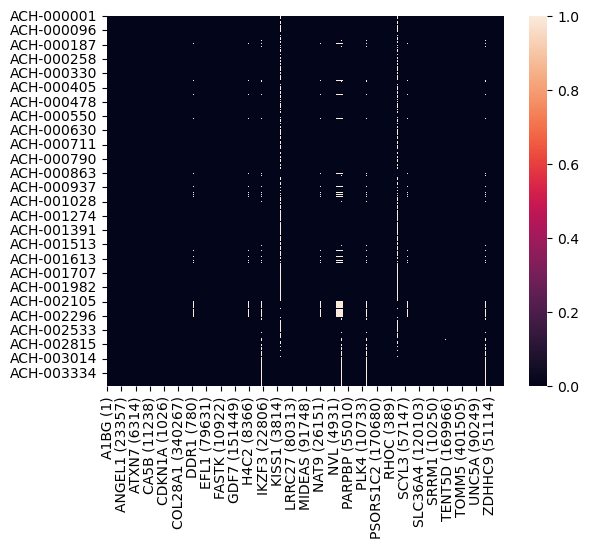

In [10]:
sns.heatmap(crispr.isna())

/root/miniconda3/envs/bootcamp/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/root/miniconda3/envs/bootcamp/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


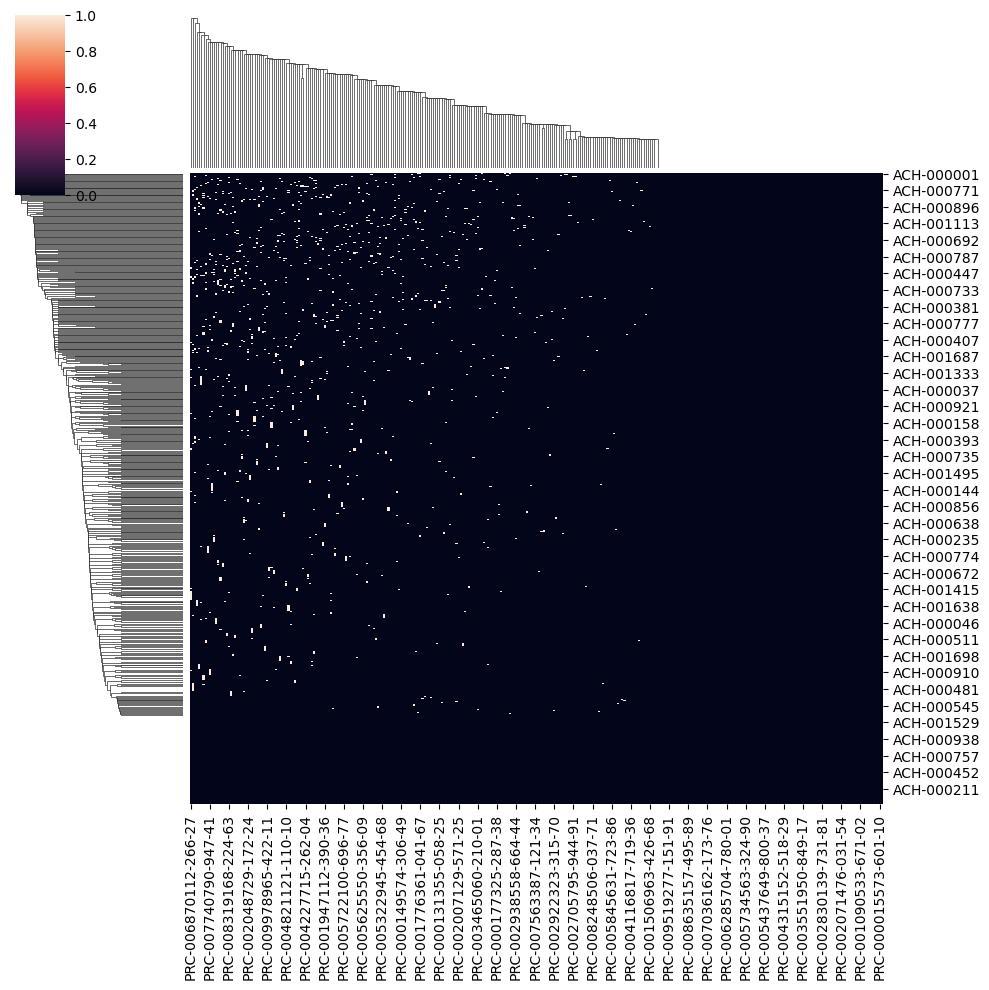

In [14]:
sns.clustermap(prism_auc.dropna(axis=0, thresh=len(prism_auc.columns)-5).isna())#the threshold requires that many non-NA values

In [12]:
#to preserve as many samples as we can
prism_filtered = prism_auc.dropna(axis=0, thresh=len(prism_auc.columns) - 5)
prism_filtered = prism_filtered.dropna(axis=1)

In [13]:
prism_filtered.isna().any(axis=0).sum(), prism_filtered.isna().any(axis=1).sum()

(np.int64(0), np.int64(0))

In [14]:
prism_filtered.isna().any(axis=0).sum(), prism_filtered.isna().any(axis=1).mean()

(np.int64(0), np.float64(0.0))

In [ ]:
pd.concat([crispr,prism_filtered],axis=1).dropna(axis=0).corr()

In [1]:
corr_output = (pd.concat([crispr,prism_filtered],axis=1).dropna(axis=0).corr().loc[crispr.columns, prism_filtered.columns])

NameError: name 'pd' is not defined